In [263]:

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scikeras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from sklearn.model_selection import train_test_split


In [292]:
spyticker = yf.Ticker("SPY")
df_SPY = spyticker.history(period="max", interval="1d", start="2002-01-01", end="2022-12-31" , auto_adjust=True, rounding=True)
df_SPY['Date']=df_SPY.index
df_SPY=df_SPY.reset_index(drop='True')
df1=df_SPY['Date'].astype('str').str.split(' ',expand=True)
df1['Date']=df1[0]
df=pd.concat([df1['Date'],df_SPY['Close']],axis=1)
print(df)

            Date   Close
0     2002-01-02   76.90
1     2002-01-03   77.78
2     2002-01-04   78.30
3     2002-01-07   77.74
4     2002-01-08   77.56
...          ...     ...
5282  2022-12-23  380.04
5283  2022-12-27  378.54
5284  2022-12-28  373.84
5285  2022-12-29  380.57
5286  2022-12-30  379.57

[5287 rows x 2 columns]


In [172]:
def SPYt(df):
    new_column=[]
    b=0
    for i,row in df.iterrows():
        if i!=0:
            a=(row['Close']-b)/b
            b=row['Close']
        else:
            a=1
            b=row['Close']
        new_column.append(a)
    t1=[1]
    t1=t1+new_column
    t1.pop()
    t2=[1]
    t2=t2+t1
    t2.pop()
    t3=[1]
    t3=t3+t1
    t3.pop()
    df.insert(len(df.columns),'SPYt',new_column)
    df.insert(len(df.columns),'SPYt1',t1)
    df.insert(len(df.columns),'SPYt2',t2)
    df.insert(len(df.columns),'SPYt3',t3)
    return df

In [173]:
def SMA(df):
    df['SMA5']=df['Close'].rolling(window=5, min_periods=1, center=False).mean()
    df['SMA10']=df['Close'].rolling(window=10, min_periods=1, center=False).mean()
    df['SMA20']=df['Close'].rolling(window=20, min_periods=1, center=False).mean()
    df['SMA50']=df['Close'].rolling(window=50, min_periods=1, center=False).mean()
    return df


In [174]:
def USD_JPY_data(df):
    data=pd.read_csv('USD_JPY Historical Data.csv')
    data['Date1'] = pd.to_datetime(data['Date'].astype('datetime64[ns]'), format='%Y%m%d')
    data1=data['Date1'].astype('str').str.split(' ',expand=True)
    data1['Date1']=data1[0]
    data2=pd.concat([data1['Date1'],data['Price']],axis=1)
    data2.rename(columns={'Price': 'USD_JPY'}, inplace=True)
    data2.index=data1['Date1']
    data2.drop('Date1', axis=1, inplace=True)
    df.index=df['Date']
    df_new=pd.concat([df,data2],axis=1,join='inner')
    return df_new

In [199]:
scaler = MinMaxScaler(feature_range=(0,1))
def df_split(df): 
    test_split=round(len(df)*0.20)
    df_for_training=df[:-test_split]
    df_for_testing=df[-test_split:]
    df_for_training_scaled = scaler.fit_transform(df_for_training)
    df_for_testing_scaled=scaler.transform(df_for_testing)
    return df_for_training_scaled,df_for_testing_scaled

In [293]:
df=SPYt(df)
df=SMA(df)
#df=USD_JPY_data(df)

In [294]:
df.drop('Date', axis=1, inplace=True)

In [295]:
df=df.drop(labels='2012-01-03',axis=0)

KeyError: "['2012-01-03'] not found in axis"

In [278]:
df=df.drop(labels='2012-01-04',axis=0)

KeyError: "['2012-01-04'] not found in axis"

In [257]:
df=df.drop(labels='2012-01-05',axis=0)

In [300]:
print(df)

       Close      SPYt     SPYt1     SPYt2     SPYt3     SMA5    SMA10  \
0      76.90  1.000000  1.000000  1.000000  1.000000   76.900   76.900   
1      77.78  0.011443  1.000000  1.000000  1.000000   77.340   77.340   
2      78.30  0.006686  0.011443  1.000000  1.000000   77.660   77.660   
3      77.74 -0.007152  0.006686  0.011443  0.011443   77.680   77.680   
4      77.56 -0.002315 -0.007152  0.006686  0.006686   77.656   77.656   
...      ...       ...       ...       ...       ...      ...      ...   
5282  380.04  0.005743 -0.014269  0.014959  0.014959  379.222  384.734   
5283  378.54 -0.003947  0.005743 -0.014269 -0.014269  379.496  383.173   
5284  373.84 -0.012416 -0.003947  0.005743  0.005743  378.726  380.843   
5285  380.57  0.018002 -0.012416 -0.003947 -0.003947  378.172  379.440   
5286  379.57 -0.002628  0.018002 -0.012416 -0.012416  378.512  378.903   

         SMA20     SMA50  
0      76.9000   76.9000  
1      77.3400   77.3400  
2      77.6600   77.6600  
3  

In [180]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
train,test=df_split(df)
trainX,trainY=createXY(train,30)
testX,testY=createXY(test,30)

In [181]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(2184, 30, 10)
(2184,)
(524, 30, 10)
(524,)


In [182]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,10)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
 
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
#grid_model = KerasRegressor(model=build_model,optimizer='rmsprop', verbose=False,)
parameters = {
    'batch_size': [16],
    'epochs': [10],
    'optimizer' : ['adam'],
}
#parameters = {'batch_size' : ([16]), 'epochs' : ([8]),  'optimizer' : (['adam'])}
#parameters=dict(batch_size=[16,20],epochs=[8,10],optimizer=['adam','Adadelta'])
grid_search = GridSearchCV(estimator = grid_model,
                          param_grid = parameters)

C:\Users\MSI-NB\AppData\Local\Temp\ipykernel_16080\4088561817.py:10: DeprecationWarning:

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



In [296]:
grid_search = grid_search.fit(trainX,trainY)
my_model=grid_search.best_estimator_.model

Epoch 1/10
110/110 [==============================] - 10s 40ms/step - loss: 0.0087 - val_loss: 0.0324
Epoch 2/10
110/110 [==============================] - 3s 28ms/step - loss: 0.0032 - val_loss: 0.0208
Epoch 3/10
110/110 [==============================] - 3s 27ms/step - loss: 0.0027 - val_loss: 0.0185
Epoch 4/10
110/110 [==============================] - 3s 28ms/step - loss: 0.0024 - val_loss: 0.0195
Epoch 5/10
110/110 [==============================] - 3s 27ms/step - loss: 0.0025 - val_loss: 0.0086
Epoch 6/10
110/110 [==============================] - 3s 29ms/step - loss: 0.0022 - val_loss: 0.0129
Epoch 7/10
110/110 [==============================] - 3s 31ms/step - loss: 0.0021 - val_loss: 0.0092
Epoch 8/10
110/110 [==============================] - 3s 29ms/step - loss: 0.0025 - val_loss: 0.0156
Epoch 9/10
110/110 [==============================] - 3s 29ms/step - loss: 0.0020 - val_loss: 0.0101
Epoch 10/10
28/28 [==============================] - 0s 9ms/step - loss: 1.1245e-04
Epoch 

In [184]:
prediction=my_model.predict(testX)
prediction_copies_array = np.repeat(prediction,10, axis=-1)
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),10)))[:,0]

original_copies_array = np.repeat(testY,10, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),10)))[:,0]

17/17 [==============================] - 1s 9ms/step


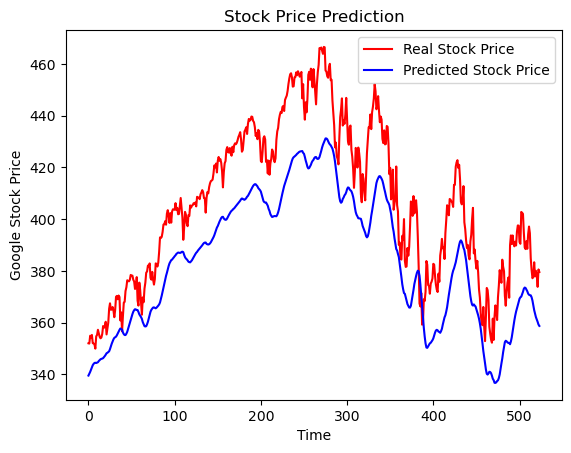

In [185]:

plt.plot(original, color = 'red', label = 'Real Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [186]:
def mean_squared_error(actual, predicted):
    n = len(actual)
    mse = np.sum((actual - predicted) ** 2) / n
    return mse

In [320]:
test_split=round(len(df)*0.20)
train_data=df[:-test_split]
test_data=df[-test_split:]
train_x=train_data.iloc[:,1:]
train_y=train_data.iloc[:,0]
test_x=test_data.iloc[:,1:] 
test_y=test_data.iloc[:,0]
def objective(trial):
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 11, 333),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 64),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05, 0.005, 0.1]),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),
        'cat_smooth' : trial.suggest_int('cat_smooth', 10, 100),
        'cat_l2': trial.suggest_int('cat_l2', 1, 20),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200),
        'cat_feature' : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 
                         32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 
                         53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
        'n_jobs' : -1, 
        'random_state': 42,
        'boosting_type': 'gbdt',
        'metric': 'rmse',
    }
    model = LGBMRegressor(**params)  
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],eval_metric='rmse', early_stopping_rounds=300, verbose=False)
    preds = model.predict(test_x)
    # 计算MSE
    test_mse = mean_squared_error(test_y, preds)
    
    return test_mse
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)


[I 2023-07-27 17:40:07,698] A new study created in memory with name: no-name-bb2ad841-71d5-47d2-baf2-35f1e0eba524
[I 2023-07-27 17:40:10,294] Trial 0 finished with value: 10950.91455422347 and parameters: {'reg_alpha': 1.7557827279149025, 'reg_lambda': 8.071022693107295, 'num_leaves': 88, 'min_child_samples': 43, 'max_depth': 62, 'learning_rate': 0.02, 'colsample_bytree': 0.4872023927096598, 'n_estimators': 4001, 'cat_smooth': 49, 'cat_l2': 4, 'min_data_per_group': 85}. Best is trial 0 with value: 10950.91455422347.
[I 2023-07-27 17:40:12,143] Trial 1 finished with value: 11441.43539695969 and parameters: {'reg_alpha': 1.1414205688255976, 'reg_lambda': 0.8626962296807298, 'num_leaves': 155, 'min_child_samples': 45, 'max_depth': 59, 'learning_rate': 0.1, 'colsample_bytree': 0.2718531594358536, 'n_estimators': 2949, 'cat_smooth': 28, 'cat_l2': 7, 'min_data_per_group': 184}. Best is trial 0 with value: 10950.91455422347.
[I 2023-07-27 17:40:12,938] Trial 2 finished with value: 11314.14572

[I 2023-07-27 17:42:29,072] Trial 20 finished with value: 11317.401671009939 and parameters: {'reg_alpha': 5.335277946153725, 'reg_lambda': 6.06737748985575, 'num_leaves': 245, 'min_child_samples': 33, 'max_depth': 27, 'learning_rate': 0.01, 'colsample_bytree': 0.3926500993766278, 'n_estimators': 5018, 'cat_smooth': 68, 'cat_l2': 15, 'min_data_per_group': 94}. Best is trial 10 with value: 10684.893019809848.
[I 2023-07-27 17:42:47,338] Trial 21 finished with value: 10742.682053545735 and parameters: {'reg_alpha': 3.3735021240564405, 'reg_lambda': 9.151362276195911, 'num_leaves': 324, 'min_child_samples': 5, 'max_depth': 43, 'learning_rate': 0.01, 'colsample_bytree': 0.4906578231916618, 'n_estimators': 4431, 'cat_smooth': 100, 'cat_l2': 12, 'min_data_per_group': 112}. Best is trial 10 with value: 10684.893019809848.
[I 2023-07-27 17:43:01,473] Trial 22 finished with value: 10707.33295644882 and parameters: {'reg_alpha': 3.9670502408528234, 'reg_lambda': 8.951672173916842, 'num_leaves': 

[I 2023-07-27 17:44:44,015] Trial 40 finished with value: 11215.249347761635 and parameters: {'reg_alpha': 1.1269568334348719, 'reg_lambda': 8.662671653361405, 'num_leaves': 106, 'min_child_samples': 42, 'max_depth': 56, 'learning_rate': 0.02, 'colsample_bytree': 0.3820330481797011, 'n_estimators': 3284, 'cat_smooth': 49, 'cat_l2': 4, 'min_data_per_group': 200}. Best is trial 25 with value: 10675.600893981324.
[I 2023-07-27 17:44:55,422] Trial 41 finished with value: 10670.85796517421 and parameters: {'reg_alpha': 2.071515389976131, 'reg_lambda': 9.43121470066644, 'num_leaves': 252, 'min_child_samples': 12, 'max_depth': 59, 'learning_rate': 0.02, 'colsample_bytree': 0.4767931476299877, 'n_estimators': 2529, 'cat_smooth': 64, 'cat_l2': 10, 'min_data_per_group': 152}. Best is trial 41 with value: 10670.85796517421.
[I 2023-07-27 17:45:05,598] Trial 42 finished with value: 10691.1989619067 and parameters: {'reg_alpha': 2.807042343459758, 'reg_lambda': 9.331159670252335, 'num_leaves': 163,

In [321]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))



reg_alpha: 2.071515389976131
reg_lambda: 9.43121470066644
num_leaves: 252
min_child_samples: 12
max_depth: 59
learning_rate: 0.02
colsample_bytree: 0.4767931476299877
n_estimators: 2529
cat_smooth: 64
cat_l2: 10
min_data_per_group: 152


In [153]:
plot_optimization_history(study)


In [346]:
test_split=round(len(df)*0.20)
train_data=df[:-test_split]
test_data=df[-test_split:]
# train_data,test_data=train_test_split(df,test_size=0.3)
# test_data,last_data=train_test_split(test_data,test_size=2/3)
# train_data=np.log(abs(train_data)+1)
# test_data=np.log(abs(test_data)+1)
train_data1=train_data.reset_index(drop=True)
valid_data1=test_data.reset_index(drop=True)
# last_data=last_data.reset_index(drop=True)

lgb_train = lgb.Dataset(train_data1.iloc[:,1:], train_data['Close'])  
lgb_eval = lgb.Dataset(valid_data1.iloc[:,1:], test_data['Close'], reference=lgb_train)
evals_result = {}
params = {
         'objective' : 'regression',
        'reg_alpha': 2.071515389976131,
        'reg_lambda': 9.43121470066644,
        'num_leaves': 252,
        'min_child_samples': 12,
        'max_depth': 59,
        'learning_rate': 0.02,
        'colsample_bytree': 0.4767931476299877,
        'n_estimators': 2529,
        'cat_smooth' : 64,
        'cat_l2': 10,
        'min_data_per_group': 152,
        'cat_feature' : [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 
                         32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 
                         53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
        'n_jobs' : -1, 
        'random_state': 42,
        'boosting_type': 'gbdt',
        'metric': 'l2',
    }
  
# Add verbosity=2 to print messages while running boosting  
my_model = lgb.train(params, lgb_train, num_boost_round=5000, valid_sets=lgb_eval, early_stopping_rounds=100,evals_result=evals_result)  
   
lgb_predictions = my_model.predict(last_data.iloc[:,1:], num_iteration=my_model.best_iteration)  

          SPYt     SPYt1     SPYt2     SPYt3     SMA5    SMA10     SMA20  \
0    -0.001802  0.006687 -0.004779 -0.004779  282.086  280.818  280.1760   
1     0.001526 -0.001741  0.000000  0.000000  183.936  183.705  182.1760   
2     0.008757  0.000939  0.033542  0.033542   94.916   92.805   93.4725   
3     0.002399  0.000576  0.008621  0.008621  103.798  103.097  101.3600   
4     0.002460  0.010273  0.002111  0.002111  423.374  421.517  420.2265   
...        ...       ...       ...       ...      ...      ...       ...   
3695 -0.000846  0.002758  0.014749  0.014749   93.790   94.477   94.3580   
3696  0.000574  0.041363 -0.078338 -0.078338   87.880   89.174   90.6125   
3697  0.001560  0.005082 -0.003019 -0.003019  185.504  184.809  182.9025   
3698  0.009382 -0.012719  0.000830  0.000830   71.730   70.189   69.6280   
3699  0.009157 -0.011535 -0.000276 -0.000276  180.530  180.115  179.2045   

         SMA50  
0     272.6322  
1     177.4872  
2      93.8742  
3      99.9804  
4 

D:\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's l2: 36.3819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's l2: 35.342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's l2: 34.3512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[163]	valid_0's l2: 33.3805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[164]	valid_0's l2: 33.3144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[165]	valid_0's l2: 32.3745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[166]	valid_0's l2: 31.4589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[167]	valid_0's l2: 30.6037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[168]	valid_0's l2: 29.7644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[259]	valid_0's l2: 6.1695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[260]	valid_0's l2: 6.12092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[261]	valid_0's l2: 6.07724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[262]	valid_0's l2: 6.03476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[263]	valid_0's l2: 5.97178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[264]	valid_0's l2: 5.93052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[265]	valid_0's l2: 5.86952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[266]	valid_0's l2: 5.82391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[267]	valid_0's l2: 5.78571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[268]	valid_0's l2: 5.7309
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[372]	valid_0's l2: 3.86895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[373]	valid_0's l2: 3.85955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's l2: 3.8475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's l2: 3.84119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's l2: 3.83054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's l2: 3.82946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[378]	valid_0's l2: 3.82524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	valid_0's l2: 3.81518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[380]	valid_0's l2: 3.80461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[469]	valid_0's l2: 3.40336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	valid_0's l2: 3.40011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	valid_0's l2: 3.39749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	valid_0's l2: 3.39587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	valid_0's l2: 3.3931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	valid_0's l2: 3.38685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	valid_0's l2: 3.38292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	valid_0's l2: 3.38272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	valid_0's l2: 3.3791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[570]	valid_0's l2: 3.18825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[571]	valid_0's l2: 3.18476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[572]	valid_0's l2: 3.18328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[573]	valid_0's l2: 3.18293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[574]	valid_0's l2: 3.18313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[575]	valid_0's l2: 3.18458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[576]	valid_0's l2: 3.18475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[577]	valid_0's l2: 3.18593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[578]	valid_0's l2: 3.18313
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[666]	valid_0's l2: 3.07084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[667]	valid_0's l2: 3.07076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[668]	valid_0's l2: 3.06949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[669]	valid_0's l2: 3.06687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[670]	valid_0's l2: 3.06658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	valid_0's l2: 3.06677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	valid_0's l2: 3.06639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[673]	valid_0's l2: 3.0668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[674]	valid_0's l2: 3.0673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[758]	valid_0's l2: 3.00409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[759]	valid_0's l2: 3.00321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[760]	valid_0's l2: 3.00082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[761]	valid_0's l2: 3.00018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[762]	valid_0's l2: 3.00055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[763]	valid_0's l2: 2.99885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[764]	valid_0's l2: 2.99713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[765]	valid_0's l2: 2.99608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[766]	valid_0's l2: 2.99553
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[862]	valid_0's l2: 2.94172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[863]	valid_0's l2: 2.94172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[864]	valid_0's l2: 2.94134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[865]	valid_0's l2: 2.94133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[866]	valid_0's l2: 2.94151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[867]	valid_0's l2: 2.94121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[868]	valid_0's l2: 2.93986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[869]	valid_0's l2: 2.94013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[870]	valid_0's l2: 2.93904
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[967]	valid_0's l2: 2.89735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[968]	valid_0's l2: 2.89733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[969]	valid_0's l2: 2.89703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[970]	valid_0's l2: 2.89665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[971]	valid_0's l2: 2.89596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[972]	valid_0's l2: 2.89539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[973]	valid_0's l2: 2.89414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[974]	valid_0's l2: 2.89338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[975]	valid_0's l2: 2.89389
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1081]	valid_0's l2: 2.85742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1082]	valid_0's l2: 2.85773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1083]	valid_0's l2: 2.85702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1084]	valid_0's l2: 2.85702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1085]	valid_0's l2: 2.85721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1086]	valid_0's l2: 2.85658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1087]	valid_0's l2: 2.85616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1088]	valid_0's l2: 2.85576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1089]	valid_0's l2: 2.85481
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1200]	valid_0's l2: 2.83488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1201]	valid_0's l2: 2.83373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1202]	valid_0's l2: 2.83308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1203]	valid_0's l2: 2.83269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1204]	valid_0's l2: 2.83307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1205]	valid_0's l2: 2.83377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1206]	valid_0's l2: 2.83404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1207]	valid_0's l2: 2.83436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1208]	valid_0's l2: 2.83478
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1308]	valid_0's l2: 2.81615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1309]	valid_0's l2: 2.81549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1310]	valid_0's l2: 2.81573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1311]	valid_0's l2: 2.81521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1312]	valid_0's l2: 2.81437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1313]	valid_0's l2: 2.8133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1314]	valid_0's l2: 2.81348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1315]	valid_0's l2: 2.81392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1316]	valid_0's l2: 2.81385
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1406]	valid_0's l2: 2.80089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1407]	valid_0's l2: 2.80116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1408]	valid_0's l2: 2.80128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1409]	valid_0's l2: 2.80146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1410]	valid_0's l2: 2.80141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1411]	valid_0's l2: 2.80061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1412]	valid_0's l2: 2.79992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1413]	valid_0's l2: 2.79963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1414]	valid_0's l2: 2.79934
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1508]	valid_0's l2: 2.7889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1509]	valid_0's l2: 2.78885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1510]	valid_0's l2: 2.78899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1511]	valid_0's l2: 2.78904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1512]	valid_0's l2: 2.78887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1513]	valid_0's l2: 2.78887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1514]	valid_0's l2: 2.78878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1515]	valid_0's l2: 2.78838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1516]	valid_0's l2: 2.7885
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1642]	valid_0's l2: 2.78291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1643]	valid_0's l2: 2.78295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1644]	valid_0's l2: 2.78286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1645]	valid_0's l2: 2.78304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1646]	valid_0's l2: 2.78299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1647]	valid_0's l2: 2.78315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1648]	valid_0's l2: 2.78328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1649]	valid_0's l2: 2.78334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1650]	valid_0's l2: 2.78318
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1779]	valid_0's l2: 2.77804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1780]	valid_0's l2: 2.7779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1781]	valid_0's l2: 2.77779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1782]	valid_0's l2: 2.77738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1783]	valid_0's l2: 2.77727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1784]	valid_0's l2: 2.77735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1785]	valid_0's l2: 2.77715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1786]	valid_0's l2: 2.77706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1787]	valid_0's l2: 2.77672
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1919]	valid_0's l2: 2.77299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1920]	valid_0's l2: 2.77287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1921]	valid_0's l2: 2.77296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1922]	valid_0's l2: 2.77291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1923]	valid_0's l2: 2.773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1924]	valid_0's l2: 2.77307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1925]	valid_0's l2: 2.77284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1926]	valid_0's l2: 2.77295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1927]	valid_0's l2: 2.77307
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2072]	valid_0's l2: 2.76856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2073]	valid_0's l2: 2.76872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2074]	valid_0's l2: 2.76863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2075]	valid_0's l2: 2.76875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2076]	valid_0's l2: 2.76867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2077]	valid_0's l2: 2.76861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2078]	valid_0's l2: 2.76857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2079]	valid_0's l2: 2.76827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2080]	valid_0's l2: 2.76835
[LightGBM] [Warning] No further splits with positive gain, best 

[2151]	valid_0's l2: 2.76721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2152]	valid_0's l2: 2.76733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2153]	valid_0's l2: 2.76736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2154]	valid_0's l2: 2.76726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2155]	valid_0's l2: 2.76724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2156]	valid_0's l2: 2.76735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2157]	valid_0's l2: 2.76744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2158]	valid_0's l2: 2.76755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2159]	valid_0's l2: 2.76764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2160]	valid_0's l2: 2.76768
[LightGBM] [Warning] No further spl

[2233]	valid_0's l2: 2.7663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2234]	valid_0's l2: 2.76629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2235]	valid_0's l2: 2.76644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2236]	valid_0's l2: 2.7665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2237]	valid_0's l2: 2.76672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2238]	valid_0's l2: 2.76671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2239]	valid_0's l2: 2.76671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2240]	valid_0's l2: 2.76683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2241]	valid_0's l2: 2.767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2242]	valid_0's l2: 2.76698
[LightGBM] [Warning] No further splits 

In [ ]:
def new_variable(df,prediction):
    df.insert(len(df.columns),'LSTM',prediction)
    predict=Light_train(df)
    return predict

In [345]:

last_data=last_data.reset_index(drop=True)
last_data['Close']

0       432.93
1       402.78
2        82.13
3       242.59
4        73.58
         ...  
1053    180.04
1054     62.92
1055     87.19
1056    108.16
1057     72.01
Name: Close, Length: 1058, dtype: float64

In [343]:
lgb_predictions

array([433.11845377, 401.93938541,  81.89806598, ...,  87.40675456,
       108.07346684,  71.89221675])

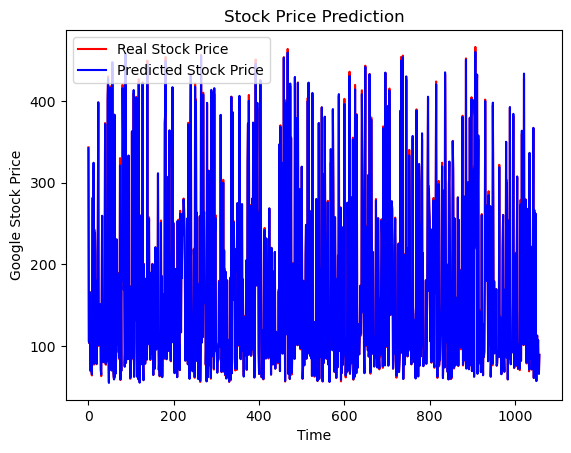

In [347]:

plt.plot(last_data['Close'], color = 'red', label = 'Real Stock Price')
plt.plot(lgb_predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

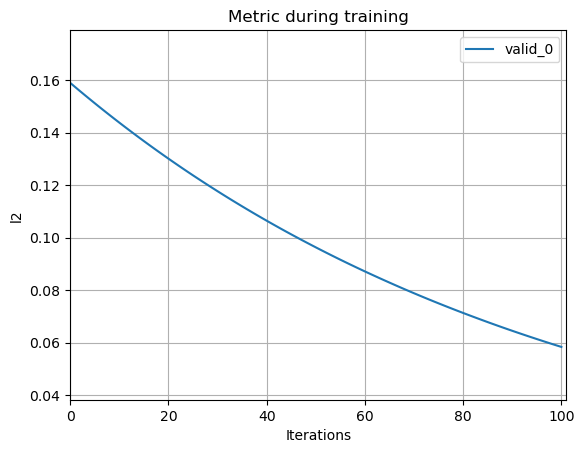

In [267]:
ax = lgb.plot_metric(evals_result, metric='l2')
plt.show()

D:\Anaconda\lib\site-packages\lightgbm\plotting.py:357: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



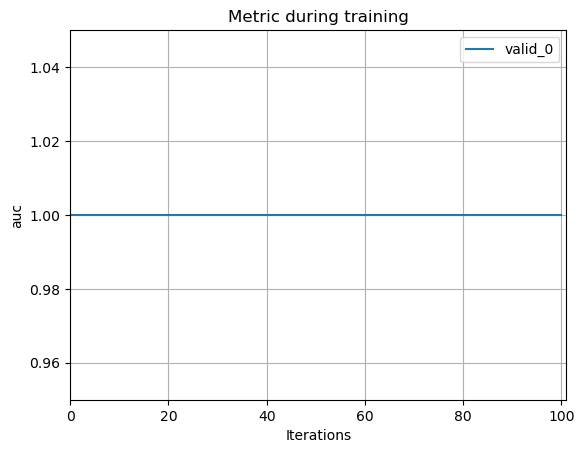

In [268]:
ax = lgb.plot_metric(evals_result, metric='auc')
plt.show()